In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from scipy.stats import ks_2samp

* primero hay que cargar nuestros datos

In [2]:
df = pd.read_csv('credit_card_default.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [4]:
df.shape

(30000, 25)

## Tratamiento de datos
* como vemos tenemos 30,000 filas y 25 columnas
* Toca hacer tratamiento a los datos

In [5]:
# Rename
df.rename(columns=lambda x: x.lower(), inplace=True) # pasa a minusculas los headers
df.rename(columns={'default payment next month':'default'}, inplace=True) # cambiamos el nombre de una columna
df.rename(columns={'pay_0':'pay_1'}, inplace=True) # cambiamos el nombre de una columna

# etiquetas de tipos de variables
bill_amt_features = ['bill_amt'+str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt'+str(i) for i in range(1,7)]
numerical_features = ['limit_bal', 'age'] + bill_amt_features + pay_amt_features

# transformando el tipo de variables
df['male'] = (df['sex'] == 1).astype('int')
df['female'] = (df['sex'] == 2).astype('int')
df['grad_school'] = (df['education'] == 1).astype('int')
df['university'] = (df['education'] == 2).astype('int')
df['high_school'] = (df['education'] == 3).astype('int')
df['married'] = (df['marriage'] == 1).astype('int')

# transfromamos los valores con -1 o -2 a 0
pay_features = ['pay_'+str(i) for i in range(1,7)]
for x in pay_features:
    df.loc[df[x] <= 0, x] = 0

# creamos variables binarias
delayed_features = ['delayed_' + str(i) for i in range(1,7)]
for pay, delayed in zip(pay_features, delayed_features):
    df[delayed] = (df[pay] > 0).astype('int')

# creamos la columna de la suma de los atrasos de los ultimos meses
df['months_delayed'] = df[delayed_features].sum(axis=1)

# por ultimo solo nos quedamos con las variables de interes
numerical_features = numerical_features + ['months_delayed']
binary_features = ['male','female','married','grad_school', 'university','high_school']
x = df[numerical_features + binary_features]
y = df['default'].astype('int')

In [6]:
df.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,university,high_school,married,delayed_1,delayed_2,delayed_3,delayed_4,delayed_5,delayed_6,months_delayed
0,1,20000,2,2,1,24,2,2,0,0,...,1,0,1,1,1,0,0,0,0,2
1,2,120000,2,2,2,26,0,2,0,0,...,1,0,0,0,1,0,0,0,1,2
2,3,90000,2,2,2,34,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,4,50000,2,2,1,37,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,5,50000,1,2,1,57,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [7]:
x.head()

,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,...,pay_amt4,pay_amt5,pay_amt6,months_delayed,male,female,married,grad_school,university,high_school
0,20000,24,3913,3102,689,0,0,0,0,689,...,0,0,0,2,0,1,1,0,1,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,1000,0,2000,2,0,1,0,0,1,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,1000,1000,5000,0,0,1,0,0,1,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,1100,1069,1000,0,0,1,1,0,1,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,9000,689,679,0,1,0,1,0,1,0


## Dividimos nuestros datos en train y test

In [ ]:
# dividimos los datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

## hacemos nuestro pipeline usando randomforest y utilizamos GridSearchCV

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

tree_pipe = Pipeline([
    ("scaler", StandardScaler()), ("tree", RandomForestClassifier())
])

# hiperparametros
param_grid = {
    "tree__max_depth":[3,4,5,6,7,8,9,10,11],
    "tree__criterion":["entropy","gini"],
    "tree__max_features":["sqrt","log2", None]
}

grid_search = GridSearchCV(tree_pipe, param_grid, cv=kf, scoring="accuracy")


## toca entrenar el modelo

In [10]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree', RandomForestClassifier())]),
             param_grid={'tree__criterion': ['entropy', 'gini'],
                         'tree__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'tree__max_features': ['sqrt', 'log2', None]},
             scoring='accuracy')

In [11]:
print(f"Mejores hiperparámetros: {grid_search.best_params_}") 
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_}")

Mejores hiperparámetros: {'tree__criterion': 'entropy', 'tree__max_depth': 8, 'tree__max_features': None}
Mejor puntuación de validación cruzada: 0.8034761904761905


como vemos en los resultados de arriba, los mejores hiperparametros para el modelo de RandomForest son:
* **criterion** = entropy
* **max depth** = 8
* **max features** = None 

obteniendo tambien un puntaje en la validación cruzada de **0.803**

## dado que ya encontramso lo que se supone son los mejores hiperparametros, volvemos a entrenar el modelo, pero ya con dichos hiperparametros

In [9]:
# ahora probemos los hiperparametros
# definimos el pipeline con los mejores hiperparametros
final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None, random_state=42))
])

# entrenamo el modelo con el conjunto de entrenamiento
final_pipe.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('tree',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        max_features=None, random_state=42))])

In [10]:
y_pred_train = final_pipe.predict(x_train)
train_accuracy = recall_score(y_train, y_pred_train)

#luego evaluamos el rendimiento con el conjunto de prueba
y_pred_test = final_pipe.predict(x_test)
test_accuracy = recall_score(y_test, y_pred_test)
print(f"recall para el conjunto de entrenamiento: {train_accuracy}")
print(f"recall para el conjunto de prueba: {test_accuracy}")

recall para el conjunto de entrenamiento: 0.3561994034938219
recall para el conjunto de prueba: 0.31668383110195675


In [ ]:
kf = StratifiedKFold(5, shuffle=True, random_state=42)
tree_score = cross_val_score(final_pipe, x_train, y_train, cv=kf)
print(f"random forest: {np.mean(tree_score)}")

random fores: 0.8022380952380953


In [16]:
# guardamos la probabilidad predichas
y_pred_prob = final_pipe.predict_proba(x_test)[:, 1]
# calculamos el AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_prob)
ks_stat, p_value = ks_2samp(y_pred_prob[y_test == 0], y_pred_prob[y_test == 1])
gini = 2 * auc_roc - 1
print(f"AUC-ROC: {auc_roc}")
print(f"KS: {ks_stat}")
print(f"Gini: {gini}")

AUC-ROC: 0.767419846853743
KS: 0.41567967515880627
Gini: 0.534839693707486


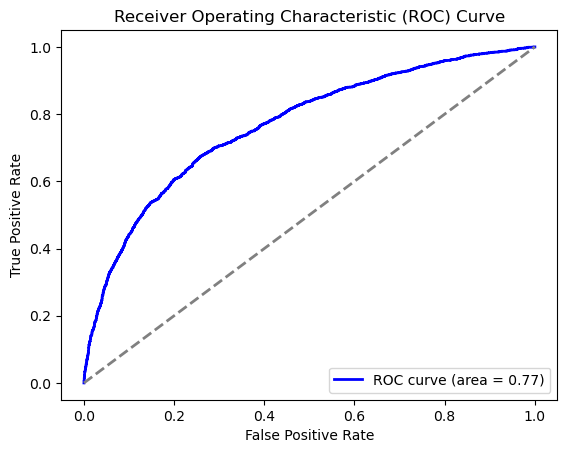

In [36]:
# obtenemos los valores de la curva ROC
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)

# graficamos la cruva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_roc:.2f})')
plt.plot([0,1], [0,1], color='gray', lw=2, linestyle="--")
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

pues nuestras metricas nos dicen lo siguiente:
* **AUC-ROC** = 0.7674, podemos decir que tenenemos un modelo util o bueno, o sea que el modelo puede diferenciar entre clases, en este contexto que estamos trabajando, el modelo puede predecir incumplimientos de pagos

* **KS** = 0.415, dado que el **ks** está más cerca de 0, podemos decir que las distribuciones de cada clase difieren, y entonces el modelo puede diferenciar de buena forma, entre los incumplidores y los no incumplidores.

* **Gini** = 0.534, esto muestra que el modelo tiene una buena discriminación

In [22]:
print(f"Por ejemplo, nos tomamos un clinte del conjunto de prueba y vemos como ha clasificado")
print(f"probabilidad predicha por el modelo: {y_pred_prob[1]}")
print(f"clase a la que realemte pertenece: {list(y_test)[1]}")

Por ejemplo, nos tomamos un clinte del conjunto de prueba y vemos como ha clasificado
probabilidad predicha por el modelo: 0.13907818155612486
clase a la que realemte pertenece: 0
